<a href="https://colab.research.google.com/github/OmarHammemi/Reinforcement-Learning-DQN-OpenAI-Gym/blob/main/Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tasks** 

The agent has to decide between two actions - moving the cart left or right - so that the pole attached to it stays upright. You can find an official leaderboard with various algorithms and visualizations at the Gym website.


As the agent observes the current state of the environment and chooses an action, the environment transitions to a new state, and also returns a reward that indicates the consequences of the action. In this task, rewards are +1 for every incremental timestep and the environment terminates if the pole falls over too far or the cart moves more then 2.4 units away from center. This means better performing scenarios will run for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real values representing the environment state (position, velocity, etc.). However, neural networks can solve the task purely by looking at the scene, so we’ll use a patch of the screen centered on the cart as an input. Because of this, our results aren’t directly comparable to the ones from the official leaderboard - our task is much harder. Unfortunately this does slow down the training, because we have to render all the frames.

Strictly speaking, we will present the state as the difference between the current screen patch and the previous one. This will allow the agent to take the velocity of the pole into account from one image.

#Packages

First, let’s import needed packages. Firstly, we need gym for the environment

In [1]:
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 85 kB/s 


We’ll also use the following from PyTorch:

neural networks (torch.nn)

optimization (torch.optim)

automatic differentiation (torch.autograd)

utilities for vision tasks (torchvision - a separate package).

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0', new_step_api=True, render_mode='single_rgb_array').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "


**Replay Memory**

We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

For this, we’re going to need two classses:

Transition - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.

ReplayMemory - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let’s define our model. But first, let’s quickly recap what a DQN is.

DQN algorithm
Our environment is deterministic, so all equations presented here are also formulated deterministically for the sake of simplicity. In the reinforcement learning literature, they would also contain expectations over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted, cumulative reward R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_tR 
t 
0
​
 
​
 =∑ 
t=t 
0
​
 
∞
​
 γ 
t−t 
0
​
 
 r 
t
​
 , where R_{t_0}R 
t 
0
​
 
​
  is also known as the return. The discount, \gammaγ, should be a constant between 00 and 11 that ensures the sum converges. It makes rewards from the uncertain far future less important for our agent than the ones in the near future that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function Q^*: State \times Action \rightarrow \mathbb{R}Q 
∗
 :State×Action→R, that could tell us what our return would be, if we were to take an action in a given state, then we could easily construct a policy that maximizes our rewards:

\pi^*(s) = \arg\!\max_a \ Q^*(s, a)
π 
∗
 (s)=arg 
a
max
​
  Q 
∗
 (s,a)
However, we don’t know everything about the world, so we don’t have access to Q^*Q 
∗
 . But, since neural networks are universal function approximators, we can simply create one and train it to resemble Q^*Q 
∗
 .

For our training update rule, we’ll use a fact that every QQ function for some policy obeys the Bellman equation:

Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))
Q 
π
 (s,a)=r+γQ 
π
 (s 
′
 ,π(s 
′
 ))
The difference between the two sides of the equality is known as the temporal difference error, \deltaδ:

\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))
δ=Q(s,a)−(r+γ 
a
max
​
 Q(s 
′
 ,a))
To minimise this error, we will use the Huber loss. The Huber loss acts like the mean squared error when the error is small, but like the mean absolute error when the error is large - this makes it more robust to outliers when the estimates of QQ are very noisy. We calculate this over a batch of transitions, BB, sampled from the replay memory:

\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)
L= 
∣B∣
1
​
  
(s,a,s 
′
 ,r) ∈ B
∑
​
 L(δ)
\text{where} \quad \mathcal{L}(\delta) = \begin{cases} \frac{1}{2}{\delta^2} & \text{for } |\delta| \le 1, \\ |\delta| - \frac{1}{2} & \text{otherwise.} \end{cases}
whereL(δ)={ 
2
1
​
 δ 
2
 
∣δ∣− 
2
1
​
 
​
  
for ∣δ∣≤1,
otherwise.
​
 
Q-network
Our model will be a convolutional neural network that takes in the difference between the current and previous screen patches. It has two outputs, representing Q(s, \mathrm{left})Q(s,left) and Q(s, \mathrm{right})Q(s,right) (where ss is the input to the network). In effect, the network is trying to predict the expected return of taking each action given the current input.

In [4]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

Input extraction
The code below are utilities for extracting and processing rendered images from the environment. It uses the torchvision package, which makes it easy to compose image transforms. Once you run the cell it will display an example patch that it extracted.

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


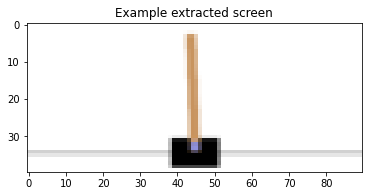

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render().transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()


#Training

Hyperparameters and utilities
This cell instantiates our model and its optimizer, and defines some utilities:

select_action - will select an action accordingly to an epsilon greedy policy. Simply put, we’ll sometimes use our model for choosing the action, and sometimes we’ll just sample one uniformly. The probability of choosing a random action will start at EPS_START and will decay exponentially towards EPS_END. EPS_DECAY controls the rate of the decay.

plot_durations - a helper for plotting the durations of episodes, along with an average over the last 100 episodes (the measure used in the official evaluations). The plot will be underneath the cell containing the main training loop, and will update after every episode.

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())